**This notebook will guide you to implement QAOA to solve MAXCUT problem using [Qiskit](https://github.com/Qiskit/qiskit)**
## Outline
1. install dependencies
2. construct MAXCUT Hamiltonian and QAOA ansatz
3. run on [Qiskit Aer simulator](https://qiskit.github.io/qiskit-aer/)
4. (Optional) use built-in Qiskit Algorithm API



## 1. Install the dependencies
To do that, we will use [uv](https://docs.astral.sh/uv/#installation) to install the dependencies.
First, install uv following the instructions [here](https://docs.astral.sh/uv/#installation).
Then, run `uv sync` to install the dependencies.

### And check version — should match the one below

In [1]:
import qiskit
print(qiskit.__version__)

1.4.3


## 2. Let's solve MAXCUT on a simple graph

Recall the MAXCUT objective is $\max_{\mathbb{s}}\frac{1}{2}\sum_{ij\in E}(1-s_is_j)$

Before going further, let's reformulate it:

$\frac{1}{2}\sum_{ij\in E}(1-s_is_j) = \frac{1}{2}\sum_{ij\in E}(-s_is_j) + const$

Therefore the above _maximization_ problem is equivalent to the problem below:

*$\max_{\mathbb{s}}\sum_{ij\in E}(-s_is_j)$*

### Constructing the Hamiltonian

MAXCUT is equivalent to the problem below:

$\max_{\mathbb{s}}\sum_{ij\in E}(-s_is_j)$

We've seen earlier that the Hamiltonian can be constructed by mapping binary variables $s_i$ onto the eigenvalues of $Z$. For the above maximization problem has the following Hamiltonian:

$\sum_{ij\in E}(-Z_iZ_j)$

### Constructing QAOA circuit

Cost Hamiltonian: $C = \sum_{ij\in E}(-Z_iZ_j)$

The full QAOA circuit:

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

Need to implement cost operator $e^{-i\gamma_p C}$ and mixer operator $e^{-i\beta_p B}$

### Let's beging by importing everything we'll need later

In [2]:
# import warnings; warnings.filterwarnings("ignore")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

### Consider the following graph

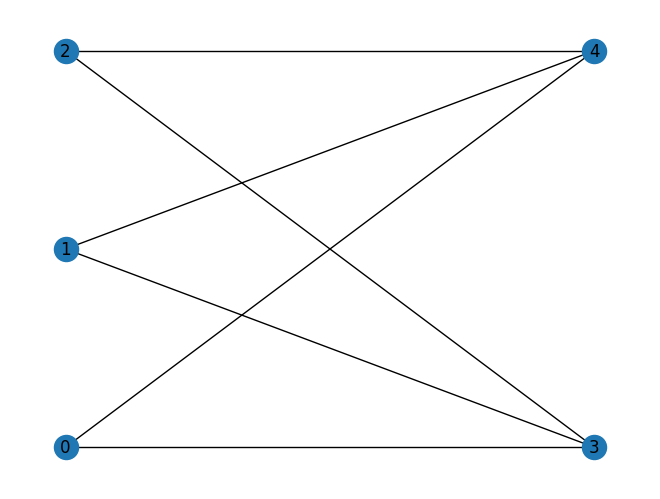

In [3]:
G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G, pos=nx.bipartite_layout(G, [0,1,2]), with_labels=True)

### We can now build the circuit for cost operator

Cost operator $ e^{-i\gamma_p C} = e^{-i\gamma_p \sum_{ij\in E}(-Z_iZ_j)}$

Note that later we will see how to do this more efficiently in Qiskit

In [4]:
def append_zz_term(qc:QuantumCircuit, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
        qc.barrier()
    return qc
    

### Let's verify that our function produces the correct circuit

Cost operator $e^{-i\gamma_p C} = e^{-i\gamma_p \sum_{ij\in E}(-Z_iZ_j)}$

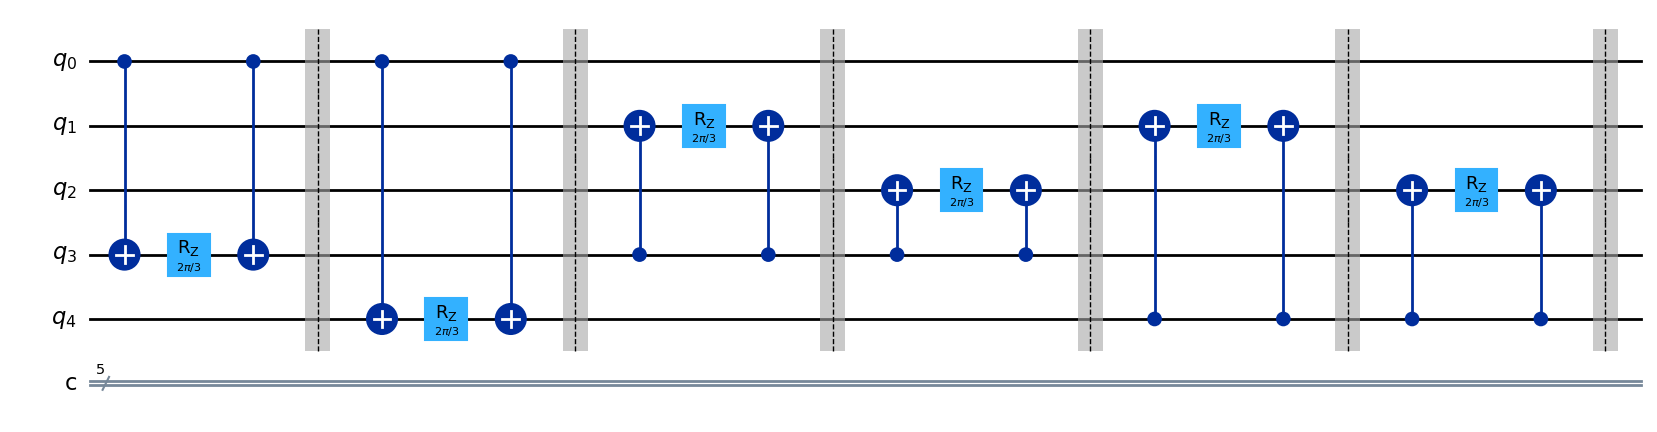

In [5]:
qc = get_cost_operator_circuit(G, np.pi / 3)
qc.draw('mpl')

### Now we need to build mixer operator

Mixer operator: $e^{-i\beta_p B} = e^{-i\beta_p \sum_{i\in V}X_i} = e^{-i\beta_p X_0}e^{-i\beta_p X_1}e^{-i\beta_p X_2}e^{-i\beta_p X_3}$

In [6]:
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc


### Let's verify the circuit

Mixer operator: $e^{-i\beta_p B} = e^{-i\beta_p \sum_{i\in V}X_i} = e^{-i\beta_p X_0}e^{-i\beta_p X_1}e^{-i\beta_p X_2}e^{-i\beta_p X_3}e^{-i\beta_p X_4}$

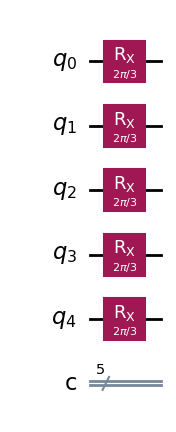

In [7]:
qc = get_mixer_operator_circuit(G, np.pi/3)
qc.draw('mpl')

### Now we are ready to build the full circuit

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

In [8]:
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc.compose(get_cost_operator_circuit(G,gamma[i]), inplace=True)
        qc.compose(get_mixer_operator_circuit(G,beta[i]), inplace=True)
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc

### Let's verify that circuit looks right

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

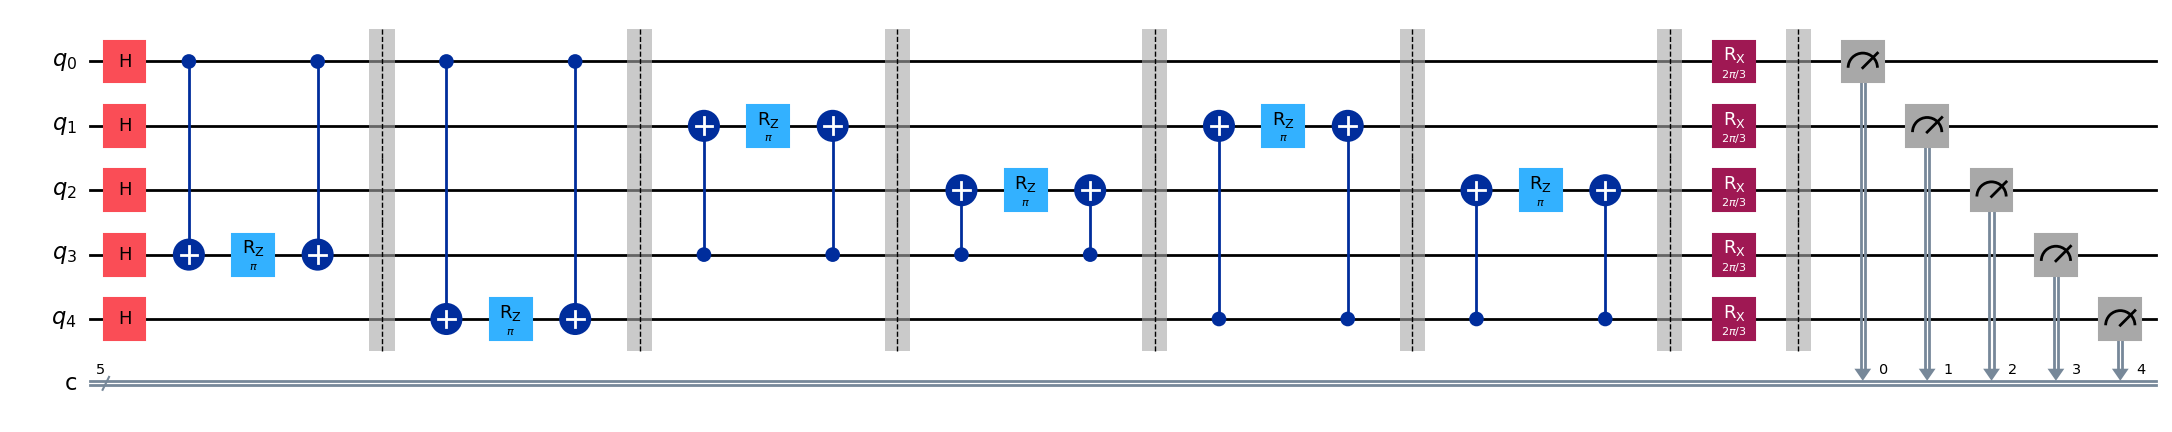

In [9]:
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw('mpl',fold=50)

### Running a circuit in Qiskit

For the purposes of this tutorial, we will be running the circuits in simulator. To run your circuits on real IBM quantum computers, all you need to do is change the backend. However, the devices are noisy, so there might be dragons!

#### Qiskit qubit ordering

Note that Qiskit uses an ordering where zeroth qubit is the rightmost (the least significant bit in the bistring),
so we need to invert the samples we received

In [10]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

Now we can run the circuit

In [11]:
backend = AerSimulator()
job = backend.run(qc)
result = job.result()
print(invert_counts(result.get_counts()))

{'01010': 35, '10001': 37, '00010': 26, '10100': 38, '01001': 32, '00100': 35, '10110': 24, '01000': 32, '01100': 36, '11111': 29, '11011': 31, '00001': 36, '01111': 36, '11001': 37, '11110': 28, '01101': 34, '10101': 29, '00101': 30, '11101': 38, '10011': 32, '01110': 37, '11100': 41, '11000': 22, '00000': 34, '00110': 34, '01011': 41, '10000': 26, '10010': 26, '00011': 23, '00111': 24, '10111': 29, '11010': 32}


### How good were these results?

To answer that, we need to compute $<\psi|C|\psi>$. Luckily, C is a classical Hamiltonian, so we can do this easily. We are going to compute -1 times the value of the cut because by convention classical optimizers minimize (this will come up shortly).

In [12]:
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

maxcut_obj('00011', G)

-6

### Estimate energy from the sample

In [13]:
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-3.0068359375

### Putting all the pieces together

As you remember, we run QAOA as a variational algorithm, so we will need a classical optimizer to optimize the parameters $\beta$, $\gamma$. We will use Constrained Optimization BY Linear Approximation (COBYLA) from `scipy.optimize`.

We need to wrap our circuit into a black-box objective function `f` that COBYLA could optimize. Note that by convention all optimizers perform _minimization_, so we had to put a minus sign in front of our objective earlier.

In [14]:
def get_black_box_objective(G,p):
    backend = AerSimulator()
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = backend.run(qc).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

### Now we can run the optimizer to get optimal parameters!

In [15]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.7900390625
       x: [ 1.872e+00  2.029e+00  1.869e+00  2.089e+00  2.812e-01
            2.112e+00  6.025e+00  2.316e+00  3.604e+00  5.930e+00]
    nfev: 94
   maxcv: 0.0

### To get the solution strings, let's run the circuit with optimal parameters

In [16]:
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(backend.run(qc).result().get_counts())
counts

{'11100': 307,
 '00011': 309,
 '00001': 53,
 '00111': 24,
 '11110': 53,
 '01100': 20,
 '11101': 56,
 '00010': 49,
 '10011': 24,
 '01011': 19,
 '00000': 21,
 '11111': 26,
 '10100': 22,
 '01000': 6,
 '11000': 23,
 '10111': 1,
 '00100': 4,
 '01101': 1,
 '11011': 3,
 '01111': 1,
 '10000': 2}

### How good are there results?

<BarContainer object of 5 artists>

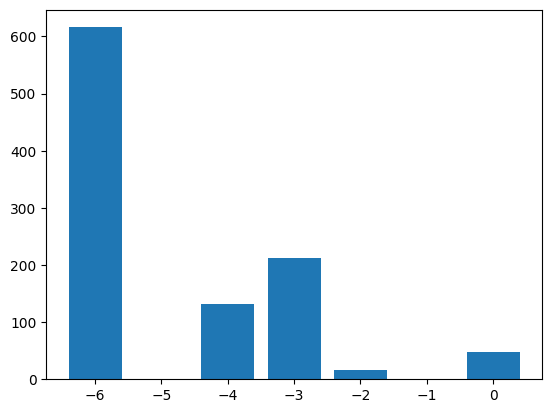

In [17]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k,G)] += v

x,y = zip(*energies.items())
plt.bar(x,y)

Pretty good! Most of the results we get correspond to good solutions!

Best string: 11100 with cut: 6


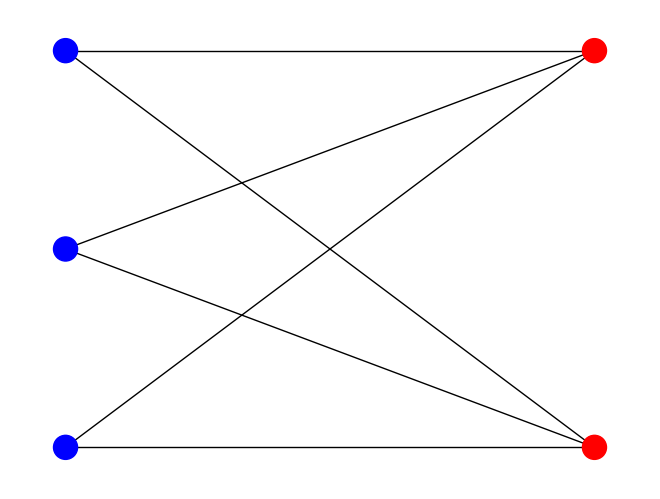

In [18]:
# get the best solution:
best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

### (Optional) Qiskit Algorithm API can help build the ansatz and Hamiltonian from problem more easily.
refer to the documentation for more details: [QAOA](https://qiskit-community.github.io/qiskit-algorithms/tutorials/05_qaoa.html)